# Battle of the Midsize University Towns in US   
    
This notebook is for IBM Applied Data Science Capstone project.    
In this notebook, we collect the midsize university towns in US with population ranging from 30,000 to 150,000 and analyze the venue distributions in them. The selected university towns are clustered based on their venues.

## Part 1. Prepare the data for university towns in US
There are three sources to prepare the data:   
1. University town list from Wikipedia  
Source:     
https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States   
2. Town location coordinates    
(Tried to use geopy, but not all accurate and takes time to get all)    
Source:   
https://simplemaps.com/data/us-cities    
Download as csv file and read in.
3. US city populations (2017 population data)     
Source:    
Top 1000 : https://www.biggestuscities.com/    
1001-2000: https://www.biggestuscities.com/2

In [1]:
# import library for data preparation
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import folium # map rendering library

### 1.1 Dataframe for the university towns in US
#### 1.1.1 Get the states of US

In [2]:
website_url = 'https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States'
tmp = requests.get(website_url).text
soup = BeautifulSoup(tmp,'lxml')

In [3]:
# Since US states are in level <h3> as other countries and regions,
# so we need to slice the part from "Alabama" to "Wyoming"
header3 = soup.findAll('h3')
region_list = []
for header in header3:
    region_list.append(header.text.split('[')[0])    # header.text has the format of 'name[edit]'

ind_start = region_list.index('Alabama')
ind_end = region_list.index('Wyoming')
us_states = region_list[ind_start:ind_end+1]
print('We got {} "states" in US.'.format(len(us_states)))

We got 51 "states" in US.


We got 50 states + DC.

#### 1.1.2 Get the univerisity towns in each state of US

In [4]:
# Get the towns in each states of US
# Each entity is in the format of 
#       'Albany (Albany State University)\nAlpharetta (Georgia State University, 
#        Gwinnett Technical College, Reinhardt University)\n ...'
list_unorder = soup.findAll('ul')
townlists = []
for lu in list_unorder:
    townlists.append(lu.text)

# The US part starts at ind = 58 and ends at ind = 123
# because some cities have unordered lists (ul) inside list.
# Some are indicated by cities/towns ended with '\xa0:'.
# e.g. 'Providence\xa0:' in us_UTown_lists[53]
us_UTown_lists = townlists[58:124]
print(len(us_UTown_lists))

66


Let's have a look at one example of the unordered list scrapped from Wikipeida.

In [5]:
# One example of the extracted university town list
us_UTown_lists[53]

'Bristol (Roger Williams University)[30]\nKingston (University of Rhode Island)[8]\nNewport (Salve Regina University)\nProvidence\xa0:\nCollege Hill (Brown University - main campus, Rhode Island School of Design)\nDowntown (University of Rhode Island - Feinstein Providence Campus, Roger Williams University)[51]\nElmhurst (Providence College)\nJewelry District (Brown University - Alpert Medical School, Johnson and Wales University)\nLower South Providence (Community College of Rhode Island)\nManton (Rhode Island College)\nSmithfield (Bryant University)\nWarwick (Community College of Rhode Island)'

We got 66 strings (51 "states" + 15 sublists for those high university density regions) as the one example shown above, towns are separated by '\n'. Each town name is followed by '(...)' with the corresponding universities inside the parenthesis.    
The info about sublist is saved to a dictionary (skip_dict) for the purpose of skipping certain items in us_UTown_lists.

#### 1.1.3 Create the university town dataframe
Put the state name, town name, and the corresponding universities to a pandas dataframe

In [6]:
df_utown = pd.DataFrame(columns=['State', 'City', 'Universities'])
# create a dictionary to skip sublist
# This will not affect the table since the main list also contains the content in the sublist
skip_dict = {'California':2, 'Georgia':1, 'Illinois':1, 'Massachusetts':2, 
             'Michigan':1, 'Ohio':2, 'Pennsylvania':5, 'Rhode Island':1}
# geolocator = Nominatim(user_agent="city_explorer")
town_ind = 0
for i, state in enumerate(us_states):
    sublist = 0
    if state in skip_dict:
        sublist = skip_dict[state]
    # print('Working on: state_ind = ', i, '; utown_list ind = ', town_ind, '; sublist = ', sublist)
    us_UTown_list = us_UTown_lists[town_ind].split('\n')
    for item in us_UTown_list:
        if '(' not in item:           # no university listed for this town, don't add to dataframe
            continue
        town = item.split(' (')[0]
        if '[' in town:               # Some town name follows reference, e.g. Anchorage[13], need to remove []
            town = town.split('[')[0]
        university = item.split(' (')[1].split(')')[0]
        """
        address = town + ', ' + state + ', United States'
        location = geolocator.geocode(address)
        if location is None:         # if fails to get the coordinates, don't add to dataframe
            continue
        lat = location.latitude
        lon = location.longitude
        """
        df_utown = df_utown.append({'State':state, 'City':town, 'Universities': university}, ignore_index=True)
    town_ind = town_ind + sublist + 1

# save to file
df_utown.to_csv('US_University_Towns.csv', encoding='utf-8')
print('UTown DataFrame created and saved into "US_University_Towns.csv".')

UTown DataFrame created and saved into "US_University_Towns.csv".


In [7]:
print('shape of the university_town dataframe = ', df_utown.shape)
df_utown.head()

shape of the university_town dataframe =  (918, 3)


,State,City,Universities
0,Alabama,Auburn,"Auburn University, Edward Via College of Osteo..."
1,Alabama,Birmingham,"University of Alabama at Birmingham, Birmingha..."
2,Alabama,Dothan,"Fortis College, Troy University Dothan Campus,..."
3,Alabama,Florence,University of North Alabama
4,Alabama,Homewood,Samford University


### 1.2 Dataframe for the populations of US cities
The population data is scrapped online: https://www.biggestuscities.com/.

In [8]:
df_city_pop = pd.DataFrame(columns=['City', 'State', 'Population'])
# First 1000
pop_url = 'https://www.biggestuscities.com/'
tmp = requests.get(pop_url).text
soup_pop = BeautifulSoup(tmp,'html')
table_pop = soup_pop.find('table', 'table-condensed')
for row in table_pop.findAll('tr')[1:]:
    col = row.findAll('td')
    city = col[1].text.lstrip().rstrip()
    state = col[2].text.lstrip().rstrip()
    population = str(col[3].text.replace(',', '').lstrip().rstrip())
    tmp = [city, state, population]
    df_city_pop = df_city_pop.append({'City':city, 'State':state, 'Population':population}, ignore_index=True)
    
# 1001 - 2000
pop_url = 'https://www.biggestuscities.com/2'
tmp = requests.get(pop_url).text
soup_pop = BeautifulSoup(tmp,'html')
table_pop = soup_pop.find('table', 'table-condensed')
for row in table_pop.findAll('tr')[1:]:
    col = row.findAll('td')
    city = col[1].text.lstrip().rstrip()
    state = col[2].text.lstrip().rstrip()
    population = str(col[3].text.replace(',', '').lstrip().rstrip())
    tmp = [city, state, population]
    df_city_pop = df_city_pop.append({'City':city, 'State':state, 'Population':population}, ignore_index=True)

# save to file for future use
df_city_pop.to_csv('US_Cities_Population_Top2000.csv', encoding='utf-8')
print('City population DataFrame created and saved into "US_Cities_Population_Top2000.csv".')

City population DataFrame created and saved into "US_Cities_Population_Top2000.csv".


In [9]:
print('shape of the city population dataframe = ', df_city_pop.shape)
df_city_pop.head()

shape of the city population dataframe =  (2000, 3)


,City,State,Population
0,New York,New York,8622698
1,Los Angeles,California,3999759
2,Chicago,Illinois,2716450
3,Houston,Texas,2312717
4,Phoenix,Arizona,1626078


### 1.3 Dataframe for the locations of US cities

In [10]:
df_loc = pd.read_csv('./uscitiesv1.5.csv')
df_loc = df_loc[['city', 'state_name', 'lat', 'lng']]
df_loc.columns = ['City', 'State', 'lat', 'lng']
print('shape of the city location dataframe = ', df_loc.shape)
df_loc.head()

shape of the city location dataframe =  (37842, 4)


,City,State,lat,lng
0,Prairie Ridge,Washington,47.1443,-122.1408
1,Edison,Washington,48.5602,-122.4311
2,Packwood,Washington,46.6085,-121.6702
3,Wautauga Beach,Washington,47.5862,-122.5482
4,Harper,Washington,47.5207,-122.5196


### 1.4 Create the final dataframe
Next, merge the three dataframes into one.    
If we look into the df_utown dataframe (from Wiki), we can see a portion of them are misnamed or in fact neighborhoods of cities, which cannot be found in the df_loc or df_city_pop dataframes. Therefore, the merged final dataframe has only 521 rows left.    
We could of course spend time correcting those town/region names, but considering that most of them are neighborhoods of large cities, and here we focus on mid-size university towns, so we'll proceed with the ~ 500 towns.

In [11]:
tmp = pd.merge(df_utown, df_city_pop, how='left', left_on=['City', 'State'], right_on=['City', 'State'])
utown_f = pd.merge(tmp, df_loc, how='left', left_on=['City', 'State'], right_on=['City', 'State'])

# remove rows with empty entities
utown_f.replace('', np.nan, inplace=True)
utown_f.dropna(inplace=True)
utown_f.reset_index(drop=True, inplace=True)

# convert population column to float
utown_f['Population'] = utown_f['Population'].astype('float')

# Create a 'Town' column by combining the city and state, so that same name cities can be well distinguished.
utown_f['Town'] = utown_f['City'] + ', ' + utown_f['State']

# I noticed the "Memphis, Tennessee" showed up twice due to one mistake in Wikipedia. Let's remove one.
utown_f = utown_f.groupby(utown_f['Town']).aggregate("first")
utown_f.reset_index(drop=True, inplace=True)

# save to file for future use
utown_f.to_csv('US_UTown_Final.csv', encoding='utf-8')
print('DataFrames combined and saved into "US_UTown_Final.csv".')
print('Shape of the final dataframe = ', utown_f.shape)
utown_f.head()

DataFrames combined and saved into "US_UTown_Final.csv".
Shape of the final dataframe =  (520, 7)


,State,City,Universities,Population,lat,lng,Town
0,Texas,Abilene,"Abilene Christian University, Hardin-Simmons U...",121885.0,32.4543,-99.7384,"Abilene, Texas"
1,Michigan,Adrian,"Adrian College, Siena Heights University",20689.0,41.8994,-84.0446,"Adrian, Michigan"
2,Ohio,Akron,University of Akron,197846.0,41.0802,-81.5219,"Akron, Ohio"
3,Georgia,Albany,Albany State University,73179.0,31.5776,-84.1762,"Albany, Georgia"
4,New York,Albany,"SUNY Albany, Siena College, Albany College of ...",98251.0,42.6664,-73.7987,"Albany, New York"


Finially, we now have our dataframe with 520 rows to proceed.

In [12]:
# finially, the dataframe to proceed include 4 columns: Town, Population, lat, lng
df_utown = utown_f[['Town', 'Population', 'lat', 'lng']]
print('Shape of the dataframe we will use is ', utown_f.shape)
print('First 5 rows of the dataframe:')
df_utown.head()

Shape of the dataframe we will use is  (520, 7)
First 5 rows of the dataframe:


,Town,Population,lat,lng
0,"Abilene, Texas",121885.0,32.4543,-99.7384
1,"Adrian, Michigan",20689.0,41.8994,-84.0446
2,"Akron, Ohio",197846.0,41.0802,-81.5219
3,"Albany, Georgia",73179.0,31.5776,-84.1762
4,"Albany, New York",98251.0,42.6664,-73.7987


### 1.5 Visualize the university towns on a map

In [13]:
# create map of US using latitude and longitude values
latitude = 37.0902
longitude = -95.7129
print('The geograpical coordinates of US are {}, {}.'.format(latitude, longitude))

map_US = folium.Map(location=[latitude, longitude], zoom_start=3)
# add markers to map
for lat, lng, town in zip(df_utown['lat'], df_utown['lng'], df_utown['Town']):
    label = '{}'.format(town)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_US)  

map_US

The geograpical coordinates of US are 37.0902, -95.7129.


### 1.6 Select mid-size university towns based on population
First, let's check the distribution of the populations in the university towns

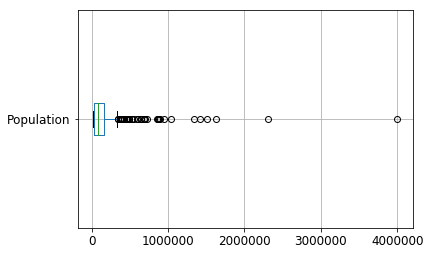

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
df_utown.boxplot(column='Population', fontsize=12, figsize=(16, 8), vert=False, ax=ax)
ax.set_xticks([0, 1000000, 2000000, 3000000, 4000000])

In [15]:
df_utown.sort_values(by='Population', ascending=False).head(20)

,Town,Population,lat,lng
279,"Los Angeles, California",3999759.0,34.1139,-118.4068
223,"Houston, Texas",2312717.0,29.7868,-95.3905
373,"Phoenix, Arizona",1626078.0,33.5722,-112.0891
424,"San Antonio, Texas",1511946.0,29.4722,-98.5247
426,"San Diego, California",1419516.0,32.8312,-117.1226
118,"Dallas, Texas",1341075.0,32.7937,-96.7662
428,"San Jose, California",1035317.0,37.3018,-121.8485
30,"Austin, Texas",950715.0,30.3006,-97.7517
235,"Jacksonville, Florida",892062.0,30.3322,-81.6749
427,"San Francisco, California",884363.0,37.7562,-122.4430


In [16]:
df_utown['Population'].describe()

count    5.200000e+02
mean     1.535173e+05
std      2.743876e+05
min      1.788500e+04
25%      3.685475e+04
50%      8.454600e+04
75%      1.601052e+05
max      3.999759e+06
Name: Population, dtype: float64

From above analysis on population, we see that the outlier university towns are in fact some of the largest cities in US, which is not what we want to focus on. So we will only keep those within 25% ~ 75% of the 'Population' distribution.    
Let's only do analysis on those in the population range of (30000, 150000).

In [17]:
# select subset of the data by restricting the population size to (30k, 150k)
upper = 150000
lower = 30000
df_utown_mid = df_utown[df_utown['Population']<upper]
df_utown_mid = df_utown_mid[df_utown_mid['Population']>lower]
df_utown_mid.reset_index(drop=True, inplace=True)
print('Size of the dataframe for towns with population between [{}, {}] = '.format(lower, upper), df_utown_mid.shape)
df_utown_mid.head()

Size of the dataframe for towns with population between [30000, 150000] =  (290, 4)


,Town,Population,lat,lng
0,"Abilene, Texas",121885.0,32.4543,-99.7384
1,"Albany, Georgia",73179.0,31.5776,-84.1762
2,"Albany, New York",98251.0,42.6664,-73.7987
3,"Alhambra, California",85396.0,34.0840,-118.1355
4,"Allentown, Pennsylvania",121283.0,40.5961,-75.4756


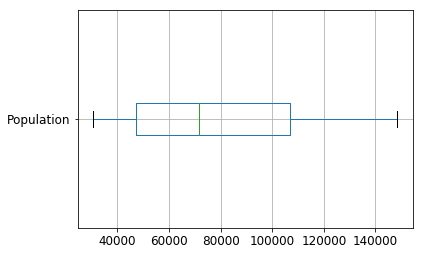

In [18]:
df_utown_mid.boxplot(column='Population', fontsize=12, vert=False)

Text(0, 0.5, 'Frequency')

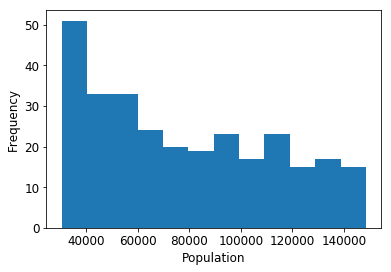

In [19]:
# plot the histogram of the population
axhis = df_utown_mid['Population'].plot.hist(bins=12, fontsize=12)
axhis.set_xlabel('Population', fontsize=12)
axhis.set_ylabel('Frequency', fontsize=12)

Now the towns left all have populations between 30,000 and 150,000. Let's visualize the midsize university towns on a map again with colors representing different population interval.

In [20]:
# color scheme based on populations
notes = ['pop ~ (30000, 60000)', 'pop ~ (60000, 90000)', 'pop ~ (90000, 120000)', 'pop ~ (120000, 150000)']
from matplotlib import cm, colors
binsize = 4
x = np.arange(binsize)
ys = [i + x + (i*x)**2 for i in range(binsize)]
colors_array = cm.plasma(np.linspace(0, 1, len(ys)))
city_color = [colors.rgb2hex(i) for i in colors_array]

# create the interval based on population
pop_bin = [i for i in range(30000, 160000, 30000)]
df_utown_mid['Pop_interval'] = pd.cut(df_utown_mid['Population'], bins=pop_bin).cat.rename_categories([0, 1, 2, 3])
print('Dataframe with the population interval added:')
df_utown_mid.head()

Dataframe with the population interval added:


,Town,Population,lat,lng,Pop_interval
0,"Abilene, Texas",121885.0,32.4543,-99.7384,3
1,"Albany, Georgia",73179.0,31.5776,-84.1762,1
2,"Albany, New York",98251.0,42.6664,-73.7987,2
3,"Alhambra, California",85396.0,34.0840,-118.1355,1
4,"Allentown, Pennsylvania",121283.0,40.5961,-75.4756,3


In [21]:
# create map of US using latitude and longitude values
# Color of the cities represent the population size
latitude = 37.0902
longitude = -95.7129
print('The geograpical coordinates of US are {}, {}.'.format(latitude, longitude))
print('The colors used for cities are ', city_color)

map_US = folium.Map(location=[latitude, longitude], zoom_start=4)
# add markers to map
cc = 0
for lat, lng, town, pop, pop_interval in zip(df_utown_mid['lat'], df_utown_mid['lng'],
                                        df_utown_mid['Town'], df_utown_mid['Population'], df_utown_mid['Pop_interval']):
    note_pop = notes[int(pop_interval)]
    label = '{}\npop={}'.format(town, int(pop))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=city_color[int(pop_interval)],
        fill=True,
        fill_color=city_color[int(pop_interval)],
        fill_opacity=0.7,
        parse_html=False).add_to(map_US)  
    cc = cc+1

#  Add the legend to the map
# '#0d0887', '#9c179e', '#ed7953', '#f0f921'
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 40px; left: 30px; width: 150px; height: 110px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Population interval <br>
                              &nbsp; (30k, 60k] &nbsp; <i class="fa fa-circle" style="color:#0d0887"></i><br>
                              &nbsp; (60k, 90k] &nbsp; <i class="fa fa-circle" style="color:#9c179e"></i><br>
                              &nbsp; (90k, 120k] &nbsp; <i class="fa fa-circle" style="color:#ed7953"></i><br>
                              &nbsp; (120k, 150k] &nbsp; <i class="fa fa-circle" style="color:#f0f921"></i>
                </div>
                ''' 

map_US.get_root().html.add_child(folium.Element(legend_html))
map_US

The geograpical coordinates of US are 37.0902, -95.7129.
The colors used for cities are  ['#0d0887', '#9c179e', '#ed7953', '#f0f921']


## Part 2. Venue exploration

This part is to explore the venues near the selected university towns.
### 2.1 Explore the nearby venues at each university town

In [45]:
# Set up Foursquare API
# To run the following, replace *** with the correct info.
CLIENT_ID = '***'       # your Foursquare ID
CLIENT_SECRET = '***'   # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ***
CLIENT_SECRET:***


In [23]:
# Function to get nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    # Input: names of the towns, location coordinates of the towns, and radius to scan
    # Output: Dataframe storing all the venue information and a counter list to store the number of 
    # venues found for each town
    venues_list=[]
    v_counts = []
    for name, lat, lng in zip(names, latitudes, longitudes):           
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        count = len(results)
        print(name, ' venue count = ', count)
        v_counts.append(count)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Town', 
                  'Town Latitude', 
                  'Town Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues, v_counts)

In [24]:
# Set up explore parameters
radius = 6000
LIMIT = 200
# during the exploration, I found that due to geo mislocation (e.g. Norman, Oklahoma),
# very few venues returned (4 for Norman, Oklahoma). The following corrects the location for Norman:    
df_utown_mid['lat'].iloc[193] = 35.2226
df_utown_mid['lng'].iloc[193] = -97.4395
df_utown_mid.to_csv('US_UTown_To_Be_Analyzed.csv', encoding='utf-8')

# get venue data
utown_venues, v_counts = getNearbyVenues(names=df_utown_mid['Town'],
                                         latitudes=df_utown_mid['lat'],
                                         longitudes=df_utown_mid['lng'],
                                         radius=radius)

C:\Users\MMX\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Abilene, Texas  venue count =  100
Albany, Georgia  venue count =  100
Albany, New York  venue count =  100
Alhambra, California  venue count =  100
Allentown, Pennsylvania  venue count =  100
Alpharetta, Georgia  venue count =  100
Altoona, Pennsylvania  venue count =  100
Ames, Iowa  venue count =  100
Ann Arbor, Michigan  venue count =  100
Annapolis, Maryland  venue count =  100
Appleton, Wisconsin  venue count =  100
Asheville, North Carolina  venue count =  100
Auburn, Alabama  venue count =  100
Bangor, Maine  venue count =  100
Beaumont, Texas  venue count =  100
Bellevue, Nebraska  venue count =  83
Bellevue, Washington  venue count =  100
Bellingham, Washington  venue count =  100
Berkeley, California  venue count =  100
Bethlehem, Pennsylvania  venue count =  100
Bettendorf, Iowa  venue count =  100
Billings, Montana  venue count =  100
Binghamton, New York  venue count =  100
Bismarck, North Dakota  venue count =  92
Blacksburg, Virginia  venue count =  65
Bloomington, Indi

Peoria, Illinois  venue count =  100
Pleasant Hill, California  venue count =  100
Pocatello, Idaho  venue count =  100
Portland, Maine  venue count =  100
Portsmouth, Virginia  venue count =  100
Poughkeepsie, New York  venue count =  100
Prescott, Arizona  venue count =  100
Princeton, New Jersey  venue count =  100
Provo, Utah  venue count =  100
Pueblo, Colorado  venue count =  100
Pullman, Washington  venue count =  46
Quincy, Massachusetts  venue count =  100
Reading, Pennsylvania  venue count =  100
Redding, California  venue count =  100
Redlands, California  venue count =  100
Richardson, Texas  venue count =  100
Richland, Washington  venue count =  100
Richmond, Indiana  venue count =  100
Richmond, Kentucky  venue count =  66
Rochester, Minnesota  venue count =  100
Rock Hill, South Carolina  venue count =  100
Rock Island, Illinois  venue count =  100
Rockford, Illinois  venue count =  100
Rocklin, California  venue count =  100
Rocky Mount, North Carolina  venue count =  

Check the size of the venues

In [25]:
# save to file for future use
utown_venues.to_csv('US_UTown_Venue.csv', encoding='utf-8')
print('Venue DataFrame saved into "US_UTown_Venue.csv".')
print('shape of the obtained venues = ', utown_venues.shape)
print('Most town venues = ', max(v_counts))
print('Least town venues = ', min(v_counts))
print('There are {} uniques categories.'.format(len(utown_venues['Venue Category'].unique())))
print('First five rows of the dataframe:')
utown_venues.head()

Venue DataFrame saved into "US_UTown_Venue.csv".
shape of the obtained venues =  (27889, 7)
Most town venues =  100
Least town venues =  38
There are 481 uniques categories.
First five rows of the dataframe:


,Town,Town Latitude,Town Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Abilene, Texas",32.4543,-99.7384,Hickory Street Cafe,32.455787,-99.736438,American Restaurant
1,"Abilene, Texas",32.4543,-99.7384,Paramount Theatre,32.451939,-99.734321,Rock Club
2,"Abilene, Texas",32.4543,-99.7384,Abi-Haus,32.450469,-99.732725,American Restaurant
3,"Abilene, Texas",32.4543,-99.7384,Monks Coffee Shop,32.451161,-99.734118,Coffee Shop
4,"Abilene, Texas",32.4543,-99.7384,The Beehive,32.453693,-99.735514,American Restaurant


In [26]:
# find how many of the venues have the word "Restaurant" in the name
print('Number of venues with "Restaurant" in their venue category',
      utown_venues[['Restaurant' in s for s in utown_venues['Venue Category']]].shape[0])

Number of venues with "Restaurant" in their venue category 7161


We can see that although we set LIMIT = 200, but the maximum number of venues we get using Foursquare is 100.    
In average, each town has 27889/290 ~ 96 venues.    
Among the 27889 venue places, 7161 (1/3) of them have the word "Restaurant" in it. We can see food-related venues are very popular in the university towns.

In [27]:
# one hot encoding
utown_onehot = pd.get_dummies(utown_venues[['Venue Category']], prefix="", prefix_sep="")
# add town column back to dataframe
utown_onehot['Town'] = utown_venues['Town'] 
# move City column to the first column
fixed_columns = [utown_onehot.columns[-1]] + list(utown_onehot.columns[:-1])
utown_onehot = utown_onehot[fixed_columns]

utown_onehot.head()

,Town,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Gate,Airport Service,Airport Terminal,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,"Abilene, Texas",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Abilene, Texas",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Abilene, Texas",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Abilene, Texas",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Abilene, Texas",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
utown_grouped = utown_onehot.groupby('Town').mean().reset_index()
print('shape of the grouped dataframe = ', utown_grouped.shape)
utown_grouped.head()

shape of the grouped dataframe =  (290, 482)


,Town,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Gate,Airport Service,Airport Terminal,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,"Abilene, Texas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.00,0.0,0.02,0.0,0.00,0.01
1,"Albany, Georgia",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.01,0.0,0.01,0.0,0.00,0.00
2,"Albany, New York",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.01,0.0,0.01,0.0,0.02,0.00
3,"Alhambra, California",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.00,0.0,0.00,0.0,0.00,0.00
4,"Allentown, Pennsylvania",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.01,0.0,0.00,0.00


Find the top 10 most common venues in each town.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Town']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
utown_venues_sorted = pd.DataFrame(columns=columns)
utown_venues_sorted['Town'] = utown_grouped['Town']

for ind in np.arange(utown_grouped.shape[0]):
    utown_venues_sorted.iloc[ind, 1:] = return_most_common_venues(utown_grouped.iloc[ind, :], num_top_venues)


In [30]:
# save to file for future use
utown_venues_sorted.to_csv('US_UTown_Venue_10_Most_Common.csv', encoding='utf-8')
print('Sorted Venue DataFrame (top 10) saved into "US_UTown_Venue_10_Most_Common.csv".')
print('shape of the common-venue-sorted dataframe = ', utown_venues_sorted.shape)
utown_venues_sorted.head()

Sorted Venue DataFrame (top 10) saved into "US_UTown_Venue_10_Most_Common.csv".
shape of the common-venue-sorted dataframe =  (290, 11)


,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abilene, Texas",Mexican Restaurant,Fast Food Restaurant,Coffee Shop,Grocery Store,American Restaurant,Discount Store,Deli / Bodega,Pharmacy,Burger Joint,Restaurant
1,"Albany, Georgia",Discount Store,Fast Food Restaurant,American Restaurant,Sandwich Place,Seafood Restaurant,Mexican Restaurant,Gym,Grocery Store,Coffee Shop,Clothing Store
2,"Albany, New York",Café,American Restaurant,Coffee Shop,Bar,Sushi Restaurant,Pub,Mexican Restaurant,Ice Cream Shop,Italian Restaurant,Theater
3,"Alhambra, California",Chinese Restaurant,Park,Sandwich Place,Szechuan Restaurant,Italian Restaurant,Burger Joint,Convenience Store,Pizza Place,Mexican Restaurant,Café
4,"Allentown, Pennsylvania",Italian Restaurant,Park,Ice Cream Shop,Pizza Place,Pub,Farmers Market,Convenience Store,Cosmetics Shop,Department Store,Bakery


### 2.2 Run k-means to cluster the U Towns into 4 clusters
Here we use utown_grouped dataframe with 481 uniques categories as features. Although some of them are actually the same or belong to the same categories, let's run it first and see what comes out.

In [31]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 4
utown_grouped_clustering = utown_grouped.drop('Town', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(utown_grouped_clustering)

# add clustering labels to sorted utown
utown_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

utown_merged = df_utown_mid
utown_merged['Vcount'] = v_counts
utown_merged = utown_merged.join(utown_venues_sorted.set_index('Town'), on='Town')

utown_merged.head()

,Town,Population,lat,lng,Pop_interval,Vcount,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abilene, Texas",121885.0,32.4543,-99.7384,3,100,3,Mexican Restaurant,Fast Food Restaurant,Coffee Shop,Grocery Store,American Restaurant,Discount Store,Deli / Bodega,Pharmacy,Burger Joint,Restaurant
1,"Albany, Georgia",73179.0,31.5776,-84.1762,1,100,3,Discount Store,Fast Food Restaurant,American Restaurant,Sandwich Place,Seafood Restaurant,Mexican Restaurant,Gym,Grocery Store,Coffee Shop,Clothing Store
2,"Albany, New York",98251.0,42.6664,-73.7987,2,100,2,Café,American Restaurant,Coffee Shop,Bar,Sushi Restaurant,Pub,Mexican Restaurant,Ice Cream Shop,Italian Restaurant,Theater
3,"Alhambra, California",85396.0,34.0840,-118.1355,1,100,1,Chinese Restaurant,Park,Sandwich Place,Szechuan Restaurant,Italian Restaurant,Burger Joint,Convenience Store,Pizza Place,Mexican Restaurant,Café
4,"Allentown, Pennsylvania",121283.0,40.5961,-75.4756,3,100,1,Italian Restaurant,Park,Ice Cream Shop,Pizza Place,Pub,Farmers Market,Convenience Store,Cosmetics Shop,Department Store,Bakery


In [32]:
# save to file for future use
utown_merged.to_csv('US_UTown_Merged.csv', encoding='utf-8')
print('DataFrame saved into "US_UTown_Merged.csv".')

DataFrame saved into "US_UTown_Merged.csv".


### 2.3 Visualize the clustering

In [33]:
# create map
latitude = 37.0902
longitude = -95.7129
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.plasma(np.linspace(0, 1, len(ys)))
town_color = [colors.rgb2hex(i) for i in colors_array]
print('used color : ', town_color)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(utown_merged['lat'], utown_merged['lng'], utown_merged['Town'], utown_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=town_color[cluster],
        fill=True,
        fill_color=town_color[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
#  Add the legend to the map
# '#0d0887', '#9c179e', '#ed7953', '#f0f921'
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 40px; left: 30px; width: 150px; height: 110px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Population interval <br>
                              &nbsp; Cluster 0 &nbsp; <i class="fa fa-circle" style="color:#0d0887"></i><br>
                              &nbsp; Cluster 1 &nbsp; <i class="fa fa-circle" style="color:#9c179e"></i><br>
                              &nbsp; Cluster 2 &nbsp; <i class="fa fa-circle" style="color:#ed7953"></i><br>
                              &nbsp; Cluster 3 &nbsp; <i class="fa fa-circle" style="color:#f0f921"></i>
                </div>
                ''' 

map_clusters.get_root().html.add_child(folium.Element(legend_html))
map_clusters

used color :  ['#0d0887', '#9c179e', '#ed7953', '#f0f921']


Interestingly, we can see the clustering of university towns based on venues is quite location dependent. It indicates that although university towns usually have people gathered from the whole world, the life style of each town is clearly influenced by the regional culture.     
Let's have a look at some examples in each category:

In [34]:
# cluster 0
utown_merged.loc[utown_merged['Cluster Labels'] == 0, utown_merged.columns[[0] + list(range(7, utown_merged.shape[1]))]].head()

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"Beaumont, Texas",Mexican Restaurant,Italian Restaurant,American Restaurant,Bakery,Pizza Place,Sandwich Place,Deli / Bodega,Grocery Store,Gym,Seafood Restaurant
33,"Bryan, Texas",Mexican Restaurant,Burger Joint,Coffee Shop,Bar,Pizza Place,Steakhouse,BBQ Joint,Fast Food Restaurant,American Restaurant,Fried Chicken Joint
36,"Caldwell, Idaho",Coffee Shop,Burger Joint,Pizza Place,Grocery Store,Gas Station,Fast Food Restaurant,American Restaurant,Mexican Restaurant,Chinese Restaurant,Discount Store
37,"Camarillo, California",Clothing Store,Coffee Shop,Mexican Restaurant,Burger Joint,Breakfast Spot,Italian Restaurant,Sporting Goods Shop,Grocery Store,Pizza Place,Taco Place
40,"Carson, California",Japanese Restaurant,Coffee Shop,Mexican Restaurant,Bakery,Brewery,Burger Joint,Seafood Restaurant,Fast Food Restaurant,Café,American Restaurant


In [35]:
# cluster 1
utown_merged.loc[utown_merged['Cluster Labels'] == 1, utown_merged.columns[[0] + list(range(7, utown_merged.shape[1]))]].head()

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Alhambra, California",Chinese Restaurant,Park,Sandwich Place,Szechuan Restaurant,Italian Restaurant,Burger Joint,Convenience Store,Pizza Place,Mexican Restaurant,Café
4,"Allentown, Pennsylvania",Italian Restaurant,Park,Ice Cream Shop,Pizza Place,Pub,Farmers Market,Convenience Store,Cosmetics Shop,Department Store,Bakery
5,"Alpharetta, Georgia",American Restaurant,Coffee Shop,Fast Food Restaurant,New American Restaurant,Sushi Restaurant,Pizza Place,Ice Cream Shop,Mexican Restaurant,Movie Theater,Mediterranean Restaurant
12,"Auburn, Alabama",American Restaurant,Grocery Store,Coffee Shop,Pizza Place,Mexican Restaurant,BBQ Joint,Sandwich Place,Burger Joint,Pharmacy,Deli / Bodega
13,"Bangor, Maine",Hotel,American Restaurant,Department Store,Ice Cream Shop,Mexican Restaurant,Sushi Restaurant,Deli / Bodega,Sandwich Place,Brewery,Clothing Store


In [36]:
# cluster 2
utown_merged.loc[utown_merged['Cluster Labels'] == 2, utown_merged.columns[[0] + list(range(7, utown_merged.shape[1]))]].head()

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Albany, New York",Café,American Restaurant,Coffee Shop,Bar,Sushi Restaurant,Pub,Mexican Restaurant,Ice Cream Shop,Italian Restaurant,Theater
7,"Ames, Iowa",Coffee Shop,Bar,Grocery Store,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Café,American Restaurant,Sandwich Place,Gym / Fitness Center
8,"Ann Arbor, Michigan",Coffee Shop,Ice Cream Shop,Bar,Pizza Place,Burger Joint,Record Shop,Korean Restaurant,Grocery Store,Mexican Restaurant,Tea Room
9,"Annapolis, Maryland",Bar,Seafood Restaurant,Coffee Shop,BBQ Joint,Wine Bar,American Restaurant,Steakhouse,Pub,Ice Cream Shop,Sushi Restaurant
10,"Appleton, Wisconsin",Bar,Coffee Shop,Pizza Place,Park,Asian Restaurant,Fast Food Restaurant,American Restaurant,Sandwich Place,Mexican Restaurant,Steakhouse


In [37]:
# cluster 3
utown_merged.loc[utown_merged['Cluster Labels'] == 3, utown_merged.columns[[0] + list(range(7, utown_merged.shape[1]))]].head()

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abilene, Texas",Mexican Restaurant,Fast Food Restaurant,Coffee Shop,Grocery Store,American Restaurant,Discount Store,Deli / Bodega,Pharmacy,Burger Joint,Restaurant
1,"Albany, Georgia",Discount Store,Fast Food Restaurant,American Restaurant,Sandwich Place,Seafood Restaurant,Mexican Restaurant,Gym,Grocery Store,Coffee Shop,Clothing Store
6,"Altoona, Pennsylvania",Gas Station,Bar,Italian Restaurant,Pizza Place,Mexican Restaurant,Discount Store,Sandwich Place,American Restaurant,Steakhouse,Grocery Store
15,"Bellevue, Nebraska",Park,Fast Food Restaurant,Mexican Restaurant,Coffee Shop,Convenience Store,Chinese Restaurant,Sandwich Place,American Restaurant,Video Store,Sports Bar
28,"Bowling Green, Kentucky",Mexican Restaurant,American Restaurant,Fast Food Restaurant,Pizza Place,Coffee Shop,Bar,Donut Shop,Ice Cream Shop,Supermarket,Gym


### 2.4 Further Analysis on the data
Now let's dig deeper into the merged dataframe.

In [38]:
utown_v = pd.read_csv('US_UTown_Merged.csv')
utown_v.drop('Unnamed: 0', 1, inplace=True)
utown_v.columns = ['Town', 'Population', 'lat', 'lng', 'pop_interval', 'v_count', 'cluster_label',
                   'common1', 'common2', 'common3', 'common4', 'common5', 'common6', 'common7', 'common8', 'common9', 'common10']
utown_v.head()

,Town,Population,lat,lng,pop_interval,v_count,cluster_label,common1,common2,common3,common4,common5,common6,common7,common8,common9,common10
0,"Abilene, Texas",121885.0,32.4543,-99.7384,3,100,3,Mexican Restaurant,Fast Food Restaurant,Coffee Shop,Grocery Store,American Restaurant,Discount Store,Deli / Bodega,Pharmacy,Burger Joint,Restaurant
1,"Albany, Georgia",73179.0,31.5776,-84.1762,1,100,3,Discount Store,Fast Food Restaurant,American Restaurant,Sandwich Place,Seafood Restaurant,Mexican Restaurant,Gym,Grocery Store,Coffee Shop,Clothing Store
2,"Albany, New York",98251.0,42.6664,-73.7987,2,100,2,Café,American Restaurant,Coffee Shop,Bar,Sushi Restaurant,Pub,Mexican Restaurant,Ice Cream Shop,Italian Restaurant,Theater
3,"Alhambra, California",85396.0,34.0840,-118.1355,1,100,1,Chinese Restaurant,Park,Sandwich Place,Szechuan Restaurant,Italian Restaurant,Burger Joint,Convenience Store,Pizza Place,Mexican Restaurant,Café
4,"Allentown, Pennsylvania",121283.0,40.5961,-75.4756,3,100,1,Italian Restaurant,Park,Ice Cream Shop,Pizza Place,Pub,Farmers Market,Convenience Store,Cosmetics Shop,Department Store,Bakery


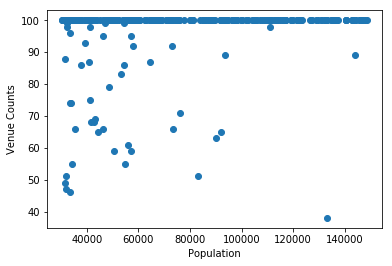

In [39]:
import matplotlib.pyplot as plt
plt.plot(utown_v['Population'], utown_v['v_count'], 'o')
plt.xlabel('Population')
plt.ylabel('Venue Counts')
plt.show()

In the above we plotted venue counts as function of the population. Intuitively, we should expect that more venues can be searched for larger towns. But we can see some rather large towns (with population >100k) only have ~ 50 venues returned from the Foursquare. This can again be due to the inaccurate information on the location data for those cities. 

Next, let's see among the top 3 most common venues, how many unique categories there are.

In [40]:
top = set()
for i in range(1,2):
    col = 'common{}'.format(i)
    tmp = utown_v[col].values.tolist()
    top = top.union(set(tmp))
    
print(len(top))
top

36


{'American Restaurant',
 'BBQ Joint',
 'Bakery',
 'Bar',
 'Beach',
 'Brewery',
 'Burger Joint',
 'Café',
 'Cajun / Creole Restaurant',
 'Caribbean Restaurant',
 'Chinese Restaurant',
 'Clothing Store',
 'Coffee Shop',
 'Convenience Store',
 'Deli / Bodega',
 'Discount Store',
 'Donut Shop',
 'Fast Food Restaurant',
 'Gas Station',
 'Grocery Store',
 'Gym',
 'Hotel',
 'Ice Cream Shop',
 'Italian Restaurant',
 'Japanese Restaurant',
 'Korean Restaurant',
 'Mexican Restaurant',
 'Middle Eastern Restaurant',
 'Park',
 'Pizza Place',
 'Racetrack',
 'Restaurant',
 'Sandwich Place',
 'Sushi Restaurant',
 'Theater',
 'Trail'}

So, among the most common venues in all the 290 towns, there are 36 unique types. We can see most of them are restaurants (food-related).    
Repeat this for each cluster,

In [41]:
utmp = utown_v[utown_v['cluster_label']==0]
top = set()
for i in range(1,2):
    col = 'common{}'.format(i)
    tmp = utmp[col].values.tolist()
    top = top.union(set(tmp))
    
print(len(top))
top

11


{'Burger Joint',
 'Clothing Store',
 'Coffee Shop',
 'Fast Food Restaurant',
 'Grocery Store',
 'Hotel',
 'Japanese Restaurant',
 'Mexican Restaurant',
 'Pizza Place',
 'Sandwich Place',
 'Theater'}

In [42]:
utmp = utown_v[utown_v['cluster_label']==1]
top = set()
for i in range(1,2):
    col = 'common{}'.format(i)
    tmp = utmp[col].values.tolist()
    top = top.union(set(tmp))
    
print(len(top))
top

23


{'American Restaurant',
 'Bakery',
 'Beach',
 'Brewery',
 'Burger Joint',
 'Café',
 'Cajun / Creole Restaurant',
 'Chinese Restaurant',
 'Clothing Store',
 'Coffee Shop',
 'Deli / Bodega',
 'Donut Shop',
 'Fast Food Restaurant',
 'Grocery Store',
 'Gym',
 'Hotel',
 'Ice Cream Shop',
 'Italian Restaurant',
 'Korean Restaurant',
 'Mexican Restaurant',
 'Park',
 'Pizza Place',
 'Sandwich Place'}

In [43]:
utmp = utown_v[utown_v['cluster_label']==2]
top = set()
for i in range(1,2):
    col = 'common{}'.format(i)
    tmp = utmp[col].values.tolist()
    top = top.union(set(tmp))
    
print(len(top))
top

13


{'American Restaurant',
 'Bar',
 'Brewery',
 'Café',
 'Coffee Shop',
 'Grocery Store',
 'Mexican Restaurant',
 'Middle Eastern Restaurant',
 'Pizza Place',
 'Restaurant',
 'Sandwich Place',
 'Sushi Restaurant',
 'Trail'}

In [44]:
utmp = utown_v[utown_v['cluster_label']==3]
top = set()
for i in range(1,2):
    col = 'common{}'.format(i)
    tmp = utmp[col].values.tolist()
    top = top.union(set(tmp))
    
print(len(top))
top

18


{'American Restaurant',
 'BBQ Joint',
 'Bar',
 'Burger Joint',
 'Caribbean Restaurant',
 'Clothing Store',
 'Coffee Shop',
 'Convenience Store',
 'Discount Store',
 'Fast Food Restaurant',
 'Gas Station',
 'Grocery Store',
 'Hotel',
 'Mexican Restaurant',
 'Park',
 'Pizza Place',
 'Racetrack',
 'Sandwich Place'}

## Part 3. Conclusion
Based on current analysis on 290 university towns with population among (30000, 150000), we can conclude that,    
- Food-related venues are most popular in the university towns in US.   
- Considering the most common venue category, “Restaurant”, “Coffee Shop”, “Convenience/Grocery Store”, and “Bar/Brewery” are most frequent in all the 4 groups we clustered into.   
- The clustering of the university towns based on venue distributions shows clear dependency on the geometrical location of the town, indicating that the life style of each town is clearly influenced by the regional culture although people in the universities usually comes from all over the US/world.      

By devoting more time to this, there are a few ways to improve the analysis:
- We could find ways to combine the 481 venue categories into more representative features, so that the clustering may give better results. Also, if more information about the town can be gathered, such as the university related features, household income of the town, etc., we can do better clustering on the university towns.
- Another improvement can come from more accurate location data. Clearly some towns’ location coordinates from the online resource are not very accurate, resulting in incomplete/wrong venue information. 
- If there is no limitation from Foursquare API (i.e. it is possible to obtain a more comprehensive exploration of the nearby venues), the clustering of the university towns can also be improved. Ways to collect more data using Foursquare need to be studied.